## Uses File : vrbo_formatted.csv

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LassoCV
import re
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV

C:\Users\yuto1\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv("vrbo_formatted.csv")

# EDA #
# Replace spaces in column names with underscores
df.columns = df.columns.str.replace(' ', '_')

# Remove id and amenities_text columns
df = df.drop(['_id', 'amenities_text', 'facilitates_text', 'reviews_text', 'name', 'vrbo_near', 'vrbo_text'], axis=1)

# Change number of bedroom to numerical
df['number_of_bedroom'] = df['number_of_bedroom'].str.extract('(\d+)').astype(float)
df['number_of_bedroom'] = df['number_of_bedroom'].astype(float)

# Replace null or NA values with custom values in different columns
df['number_bathrooms'] = df['number_bathrooms'].fillna('0') #no bathroom listing so the assumption is no bathroom
df['number_baths'] = df['number_baths'].fillna('0') #no bath listing so the assumption is no bath
df['number_beds'] = df['number_beds'].fillna('1') #None of the values under 'no of bedroom' was null therefore at least 1 bed has been assumed
df['vrbo_area_sq'] = df['vrbo_area_sq'].fillna('300') #no area sq listing so the assumption is min 300 sq feet as per International Residential Code (IRC)
df['vrbo_number_images'] = df['vrbo_number_images'].fillna('1') #Atleast 1 image has to be present for a property to be present on VRBO

# Convert the star_rating column to categorical
df['star_rating'] = df['star_rating'].astype('category')

# Replace empty cells with category '99'
df['star_rating'] = df['star_rating'].cat.add_categories(['99']).fillna('99')

# Now price has 2 null values which we can remove from our analysis and price is the predictor variable
df = df.dropna()

# Display the number of null, NA and NaN values per column
print("Number of null, NA and NaN values per column:")
print(df.isnull().sum())

# Convert object data type to string
# Convert object data type to int
df['number_bathrooms'] = df['number_bathrooms'].astype(str).str.extract('(\d+)').astype(float)
df['number_baths'] = df['number_baths'].astype(str).str.extract('(\d+)').astype(float)
df['number_beds'] = df['number_beds'].astype(str).str.extract('(\d+)').astype(float)
df['number_facilitates'] = df['number_facilitates'].astype(str).str.extract('(\d+)').astype(float)
df['number_of_bedroom'] = df['number_of_bedroom'].astype(str).str.extract('(\d+)').astype(float)
df['vrbo_area_sq'] = df['vrbo_area_sq'].astype(str).str.extract('(\d+)').astype(float)
df['vrbo_number_images'] = df['vrbo_number_images'].astype(str).str.extract('(\d+)').astype(float)

# Convert type and city to dummies
dummy_type = pd.get_dummies(df['vrbo_type'], prefix='vrbo_type')
dummy_city = pd.get_dummies(df['vrbo_city'], prefix='vrbo_city')
# merge the original dataframe with the dummy variables
df = pd.concat([df, dummy_type,dummy_city], axis=1)

# remove vrbo_type and city columns from main df
df = df.drop(['vrbo_city', 'vrbo_type'], axis=1)

print(df.info())
print(display(df))


Number of null, NA and NaN values per column:
number_amenities      0
number_bathrooms      0
number_baths          0
number_beds           0
number_facilitates    0
number_of_bedroom     0
number_reviews        0
number_sleepers       0
rank                  0
star_rating           0
vrbo_area_sq          0
vrbo_city             0
vrbo_number_images    0
vrbo_price            0
vrbo_type             0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2380 entries, 0 to 2502
Data columns (total 46 columns):
 #   Column                                                    Non-Null Count  Dtype   
---  ------                                                    --------------  -----   
 0   number_amenities                                          2380 non-null   int64   
 1   number_bathrooms                                          2380 non-null   float64 
 2   number_baths                                              2380 non-null   float64 
 3   number_beds                  

,number_amenities,number_bathrooms,number_baths,number_beds,number_facilitates,number_of_bedroom,number_reviews,number_sleepers,rank,star_rating,...,vrbo_city_boston massachusetts,vrbo_city_chicago illinois,vrbo_city_honolulu hawaii,vrbo_city_las vegas nevada,vrbo_city_los angeles california,vrbo_city_miami florida,vrbo_city_new york new york,vrbo_city_orlando (and vicinity) florida,vrbo_city_san francisco california,vrbo_city_washington (and vicinity) district of columbia
0,24,1.0,1.0,1.0,2.0,1.0,4,2,1,4.0,...,0,0,0,0,0,0,0,0,1,0
1,61,1.0,1.0,1.0,2.0,1.0,10,3,2,5.0,...,0,0,0,0,0,0,0,0,1,0
2,36,1.0,1.0,1.0,2.0,1.0,8,2,3,4.6,...,0,0,0,0,0,0,0,0,1,0
3,75,1.0,1.0,1.0,2.0,1.0,10,4,4,4.8,...,0,0,0,0,0,0,0,0,1,0
4,4,1.0,1.0,1.0,2.0,1.0,10,3,5,3.3,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2498,3,1.0,1.0,2.0,2.0,1.0,0,4,163,99,...,0,0,0,0,0,0,0,0,0,1
2499,41,5.0,5.0,9.0,4.0,6.0,0,14,164,99,...,0,0,0,0,0,0,0,0,0,1
2500,0,3.0,2.0,6.0,5.0,6.0,0,6,165,99,...,0,0,0,0,0,0,0,0,0,1
2501,3,1.0,1.0,2.0,2.0,1.0,0,4,166,99,...,0,0,0,0,0,0,0,0,0,1


None


C:\Users\yuto1\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:956: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(
C:\Users\yuto1\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:561: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


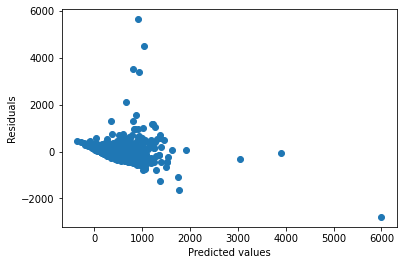

In [3]:
X = df.drop(['vrbo_price'], axis=1)
y = df['vrbo_price']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit a linear regression
lm = LinearRegression()
lm.fit(X_train, y_train)

# Predict the vrbo_price using the test set
y_pred = lm.predict(X_test)

# Calculate the residuals and plot them
residuals = y_test - y_pred

plt.scatter(y_pred, residuals)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.show()

# The residuals are not normal therefore linear regression cannot be used here. We will now explore CV lasso to estimate
# the model and get the optimal number of variables

In [4]:
# Create LassoCV object with 10-fold cross-validation
lasso_cv = LassoCV(cv=10, random_state=42)

# Fit the LassoCV object on the training data
lasso_cv.fit(X_train, y_train)

# Print the optimal alpha (lambda) value
print("Optimal alpha value:", lasso_cv.alpha_)

# Get the coefficients with non-zero values
coefficients = pd.Series(lasso_cv.coef_, index=X_train.columns)
non_zero_coefficients = coefficients[coefficients != 0]
print("\nNumber of features with non-zero coefficients:", len(non_zero_coefficients))
print(non_zero_coefficients)


Optimal alpha value: 178.4224218182231

Number of features with non-zero coefficients: 6
number_amenities       0.173354
number_sleepers       17.379477
rank                   1.201454
star_rating            0.978985
vrbo_area_sq           0.195141
vrbo_number_images     2.968637
dtype: float64


In [5]:
# Random Forest and Grid Search

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a new dataframe with y_train and non-zero x coefficients
selected_features = X_train.columns[lasso_cv.coef_ != 0]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Create a random forest regressor object
rf = RandomForestRegressor(random_state=42)

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

# Use the best hyperparameters to fit the random forest on the selected features
rf = RandomForestRegressor(**grid_search.best_params_, random_state=42)
rf.fit(X_train_selected, y_train)

# Predict using the random forest model on the test data
y_pred_rf = rf.predict(X_test_selected)

# Calculate R-squared
r2 = r2_score(y_test, y_pred_rf)
print('R-squared:', r2)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred_rf)
print('MAE:', mae)



Best hyperparameters:  {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
R-squared: 0.4687906132297027
MAE: 183.5919793015092


Text(0.5, 0, 'Random Forest Feature Importance')

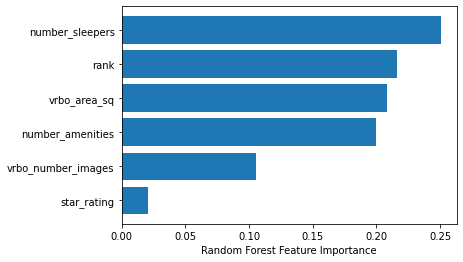

In [8]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X_train_selected.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")